とけたら dual も頑張って式変形して解きたい

# __まず cvxpy をつかってみる__

# 0 <= p_j(x_s) <= 1 は確認できた．任意の x に対して，p_j(x) \in [0, 1] とは限らないので，はみ出る場合は [0, 1] に clamp すればよいのか

# 各 p_j の実装

# 決定領域の可視化

$\displaystyle <w, x> + b = 0 \iff x_2 = -\frac{w_1}{w_2} x_1 - \frac{b}{w_2}$

# 係数を文字で代入した dataframe を作成し，最終的な行列の確認に使用する

In [1]:
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cvxpy as cp

%matplotlib inline
pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",100)

In [84]:
# load and convert data, describe problem settings, etc
data_dir_path = './inputs/toy_data/'
path_L1 = os.path.join(data_dir_path, 'L1.csv')
path_L2 = os.path.join(data_dir_path, 'L2.csv')
path_L3 = os.path.join(data_dir_path, 'L3.csv')
path_U = os.path.join(data_dir_path, 'U.csv')

df_L1 = pd.read_csv(path_L1, index_col=0)
df_L2 = pd.read_csv(path_L2, index_col=0)
df_L3 = pd.read_csv(path_L3, index_col=0)
df_U = pd.read_csv(path_U, index_col=0)

L1 = np.array(df_L1)
L2 = np.array(df_L2)
L3 = np.array(df_L3)

L = np.stack([L1, L2, L3]) # data for pointwise constraint
U = np.array(df_U) # data for logical constriant

len_j = 3 # number of tasks (p の数)
len_h = 2 # number of logical constraints considered (cardinality of KB)
len_jl = 0 # number of pointwise constraints to be counted later


len_l_list = [] # L_j の要素数のリスト
len_s_list = [] # S_j の要素数のリスト
S = [] # data for consistency constraints 

for i in range(len_j):
    if len_h != 0:
        u = len(U)
        S_i = np.concatenate((L[i][:, :2], U), axis=0)
        S.append(S_i)
    else:
        u = 0
        S_i = L[i][:, :2]
        S.append(S_i)
    len_l_list.append(len(L[i]))
    len_jl += len(L[i])
    len_s_list.append(len(S_i))

S = np.stack(S)


c1 = 2.5 # degree of satisfaction for pointwise slacks
c2 = 2.5 # degree of satisfaction for logical slacks

c1 = 100
c2 = 100

# c1 = 1000
# c2 = 1000




# 目的関数の定義
# 1/2 x.T @ P @ x + q.T @ x
# の P と q を定義
# x = [w_{j1}, w_{j2}, b_j, ξ_{jl}, ξ_h] 
# len(x) = 23

H = np.zeros((3 * len_j + len_jl + len_h, 3 * len_j + len_jl + len_h))

for i in range(3 * len_j):  # 3 * len_j は len([w1, w2, b]) * (p の数) 
    if (i + 1) % 3 != 0:
        H[i, i] = 1


f = np.zeros((3 * len_j + len_jl + len_h, 1))

for i in range(3 * len_j + len_jl):
    f[i, 0] = c1

for i in range(3 * len_j + len_jl, 3 * len_j + len_jl + len_h, 1):
    f[i, 0] = c2

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 30 04:52:16 PM: Your problem has 23 variables, 4 constraints, and 0 parameters.
(CVXPY) Sep 30 04:52:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 30 04:52:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 30 04:52:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 30 04:52:16 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 30 04:52:16 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

(CVXPY) Sep 30 04:52:16 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 30 04:52:16 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 30 04:52:16 PM: Applying reduction QpMatrixStuffing
(CVXPY) Sep 30 04:52:16 PM: Applying reduction OSQP
(CVXPY) Sep 30 04:52:16 PM: Finished problem compilation (took 1.106e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Sep 30 04:52:16 PM: Invoking solver OSQP  to obtain a solution.
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 46, constraints m = 41
          nnz(P) + n

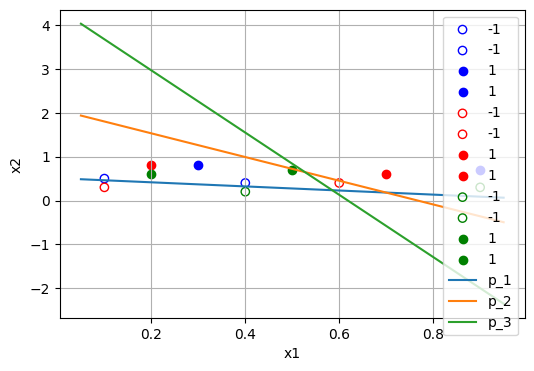

In [85]:
w_j = cp.Variable(shape=(3 * len_j, 1))  # [w1, w2, b] * 3
xi_j = cp.Variable(shape=(len_jl, 1), nonneg=True)
xi_h = cp.Variable(shape=(len_h, 1), nonneg=True)

vars = cp.vstack([w_j, xi_j, xi_h])

objective_function = cp.Minimize(1/2 * cp.quad_form(vars, H) + f.T @ vars)


# pointwise
constraint_1 = 0

for j in range(len_j):
    len_l = len_l_list[j]

    w1 = w_j[3 * j + 0, 0]
    w2 = w_j[3 * j + 1, 0]
    b =  w_j[3 * j + 2, 0]

    for l in range(len_l):
        x1 = L[j][l, 0]
        x2 = L[j][l, 1]
        y =  L[j][l, 2]

        xi = xi_j[len_l * j + l, 0]

        constraint_1 += y * (2 * (w1 * x1 + w2 * x2 + b) - 1) - 1 + 2 * xi


# logical
constraint_2 = 0

for h in range(len_h):
    tmp_constraint = 0
    tmp_j1, tmp_j2 = h, h+1

    w1_1 = w_j[3 * tmp_j1 + 0, 0]
    w2_1 = w_j[3 * tmp_j1 + 1, 0]
    b_1 =  w_j[3 * tmp_j1 + 2, 0]

    w1_2 = w_j[3 * tmp_j2 + 0, 0]
    w2_2 = w_j[3 * tmp_j2 + 1, 0]
    b_2 =  w_j[3 * tmp_j2 + 2, 0]

    xi = xi_h[h, 0]

    for u in range(len(U)):
        x1 = U[u, 0]
        x2 = U[u, 1]

        p_tmp_j1 = w1_1 * x1 + w2_1 * x2 + b_1
        p_tmp_j2 = w1_2 * x1 + w2_2 * x2 + b_2

        constraint_2 += p_tmp_j1 - p_tmp_j2 - xi



# consistency
constraint_3 = 0

for j in range(len_j):
    len_s = len_s_list[j]

    w1 = w_j[3 * j + 0, 0]
    w2 = w_j[3 * j + 1, 0]
    b =  w_j[3 * j + 2, 0]

    for s in range(len_s):
        x1 = S[j][s, 0]
        x2 = S[j][s, 1]

        constraint_3 += w1 * x1 + w2 * x2 + b



constraints = [
    constraint_1 >= 0,
    constraint_2 <= 0,
    constraint_3 >= 0,
    constraint_3 <= 1
]

problem = cp.Problem(objective_function, constraints)
result = problem.solve(verbose=True)



coeff_0 = w_j.value[:3,  0]
coeff_1 = w_j.value[3:6, 0]
coeff_2 = w_j.value[6:,  0]
coeffs = [coeff_0, coeff_1, coeff_2]


def boundary_equation_2d(x1, coeff):
    w1 = coeff[0]
    w2 = coeff[1]
    b = coeff[2]

    x = np.hstack([x1, np.ones_like(x1)])
    # w = np.array([-w1/w2, -b/w2]).reshape(-1,1)
    w = np.array([-w1/w2, -b/w2 + 0.5/w2]).reshape(-1,1)

    return x @ w

test_x = np.linspace(0.05, 0.95, 100).reshape(-1,1)

test_y_1 = boundary_equation_2d(test_x, coeff_0)
test_y_2 = boundary_equation_2d(test_x, coeff_1)
test_y_3 = boundary_equation_2d(test_x, coeff_2)



plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green']

for j in range(len_j):
    for l in range(4):
        if L[j][l, 2] == 1:
            plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
        else:
            plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

plt.plot(test_x, test_y_1, label="p_1")
plt.plot(test_x, test_y_2, label="p_2")
plt.plot(test_x, test_y_3, label="p_3")


plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

In [86]:
# 0 <= p_j(x_s) <= 1 の確認

def p(x, coeff):
    w_1 = coeff[0]
    w_2 = coeff[1]
    b = coeff[2]
    return w_1 * x[0] + w_2 * x[1] + b

coeff_0 = w_j.value[:3,  0]
coeff_1 = w_j.value[3:6, 0]
coeff_2 = w_j.value[6:,  0]
coeffs = [coeff_0, coeff_1, coeff_2]


cnt = 0

for j in range(3):
    for x_s in S[j]:
        tmp_val = p(x_s, coeffs[j])
        if tmp_val < 0:
            # print(f'p_{j}({x_s}) is less than 0')
            # print(tmp_val)
            # print()
            cnt += 1

        if tmp_val > 1:
            # print(f'p_{j}({x_s}) is more than 1')
            # print(tmp_val)
            # print()

            cnt +=1
        else:
            pass

print(f'number of violation of consistency constraints: {cnt}')

number of violation of consistency constraints: 30


In [90]:
w_j.value

array([[-6.94675366e-08],
       [-1.04819383e-07],
       [ 8.46112853e-08],
       [-4.08771844e-07],
       [-7.45573634e-07],
       [ 5.42108115e-07],
       [-1.11111055e+00],
       [ 3.70358254e-01],
       [ 9.25929332e-01]])

In [98]:
func = 0

for j in range(len_j):
    func += 1/2 * cp.norm2(w_j[3*j:3*(j+1)]) ** 2

for jl in range(len_jl):
    func += c1 * xi_j[jl, 0]

for h in range(len_h):
    func += c2 * xi_h[h, 0]

func

Expression(CONVEX, NONNEGATIVE, ())

In [96]:
len_jl

12

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 30 05:18:14 PM: Your problem has 23 variables, 84 constraints, and 0 parameters.
(CVXPY) Sep 30 05:18:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 30 05:18:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 30 05:18:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 30 05:18:14 PM: Compiling problem (target solver=ECOS).
(CVXPY) Sep 30 05:18:14 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

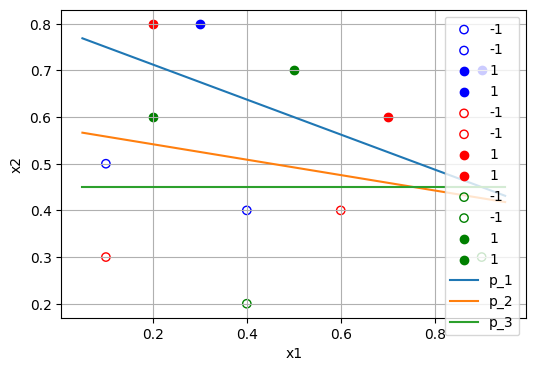

In [99]:
w_j = cp.Variable(shape=(3 * len_j, 1))  # [w1, w2, b] * 3
xi_j = cp.Variable(shape=(len_jl, 1), nonneg=True) # non-negative とか入れたほうが良さそう
xi_h = cp.Variable(shape=(len_h, 1), nonneg=True)

vars = cp.vstack([w_j, xi_j, xi_h])

# objective_function = cp.Minimize(1/2 * cp.quad_form(vars, H) + f.T @ vars)
func = 0

for j in range(len_j):
    func += 1/2 * cp.norm2(w_j[3*j:3*(j+1)]) ** 2

for jl in range(len_jl):
    func += c1 * xi_j[jl, 0]

for h in range(len_h):
    func += c2 * xi_h[h, 0]

objective_function = cp.Minimize(func)




constraints_2 = []

# pointwise
for j in range(len_j):
    len_l = len_l_list[j]

    w1 = w_j[3 * j + 0, 0]
    w2 = w_j[3 * j + 1, 0]
    b =  w_j[3 * j + 2, 0]

    for l in range(len_l):
        x1 = L[j][l, 0]
        x2 = L[j][l, 1]
        y =  L[j][l, 2]

        xi = xi_j[len_l * j + l, 0]

        constraints_2 += [
            y * (2 * (w1 * x1 + w2 * x2 + b) - 1) >= 1 - 2 * xi
        ]


# logical
for h in range(len_h):
    tmp_constraint = 0
    tmp_j1, tmp_j2 = h, h+1

    w1_1 = w_j[3 * tmp_j1 + 0, 0]
    w2_1 = w_j[3 * tmp_j1 + 1, 0]
    b_1 =  w_j[3 * tmp_j1 + 2, 0]

    w1_2 = w_j[3 * tmp_j2 + 0, 0]
    w2_2 = w_j[3 * tmp_j2 + 1, 0]
    b_2 =  w_j[3 * tmp_j2 + 2, 0]

    xi = xi_h[h, 0]

    for u in range(len(U)):
        x1 = U[u, 0]
        x2 = U[u, 1]

        p_tmp_j1 = w1_1 * x1 + w2_1 * x2 + b_1
        p_tmp_j2 = w1_2 * x1 + w2_2 * x2 + b_2

        constraints_2 += [
            p_tmp_j1 - p_tmp_j2 - xi <= 0,
        ]



# consistency
for j in range(len_j):
    len_s = len_s_list[j]

    w1 = w_j[3 * j + 0, 0]
    w2 = w_j[3 * j + 1, 0]
    b =  w_j[3 * j + 2, 0]

    for s in range(len_s):
        x1 = S[j][s, 0]
        x2 = S[j][s, 1]

        constraints_2 += [
            w1 * x1 + w2 * x2 + b >= 0,
            w1 * x1 + w2 * x2 + b <= 1
        ]


problem = cp.Problem(objective_function, constraints_2)
result = problem.solve(verbose=True)



coeff_0 = w_j.value[:3,  0]
coeff_1 = w_j.value[3:6, 0]
coeff_2 = w_j.value[6:,  0]
coeffs = [coeff_0, coeff_1, coeff_2]


def boundary_equation_2d(x1, coeff):
    w1 = coeff[0]
    w2 = coeff[1]
    b = coeff[2]

    x = np.hstack([x1, np.ones_like(x1)])
    # w = np.array([-w1/w2, -b/w2]).reshape(-1,1)
    w = np.array([-w1/w2, -b/w2 + 0.5/w2]).reshape(-1,1)

    return x @ w

test_x = np.linspace(0.05, 0.95, 100).reshape(-1,1)

test_y_1 = boundary_equation_2d(test_x, coeff_0)
test_y_2 = boundary_equation_2d(test_x, coeff_1)
test_y_3 = boundary_equation_2d(test_x, coeff_2)



plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green']

for j in range(len_j):
    for l in range(4):
        if L[j][l, 2] == 1:
            plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
        else:
            plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

plt.plot(test_x, test_y_1, label="p_1")
plt.plot(test_x, test_y_2, label="p_2")
plt.plot(test_x, test_y_3, label="p_3")


plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

In [87]:
# 0 <= p_j(x_s) <= 1 の確認

def p(x, coeff):
    w_1 = coeff[0]
    w_2 = coeff[1]
    b = coeff[2]
    return w_1 * x[0] + w_2 * x[1] + b

coeff_0 = w_j.value[:3,  0]
coeff_1 = w_j.value[3:6, 0]
coeff_2 = w_j.value[6:,  0]
coeffs = [coeff_0, coeff_1, coeff_2]



cnt = 0

for j in range(3):
    for x_s in S[j]:
        tmp_val = p(x_s, coeffs[j])
        if tmp_val < 0:
            # print(f'p_{j}({x_s}) is less than 0')
            # print(tmp_val)
            # print()
            cnt += 1

        if tmp_val > 1:
            # print(f'p_{j}({x_s}) is more than 1')
            # print(tmp_val)
            # print()

            cnt +=1
        else:
            pass

print(f'number of violation of consistency constraints: {cnt}')

number of violation of consistency constraints: 30


In [19]:
w_j.value

array([[ 0.575     ],
       [ 0.25      ],
       [-0.56789852],
       [-0.7       ],
       [ 0.425     ],
       [ 0.30883339],
       [-2.6       ],
       [ 0.6       ],
       [ 1.1855653 ]])

In [20]:
xi_j.value

array([[0.27083333],
       [0.27083333],
       [0.27083333],
       [0.27083333],
       [0.27083333],
       [0.27083333],
       [0.27083333],
       [0.27083333],
       [0.27083333],
       [0.27083333],
       [0.27083333],
       [0.27083333]])

In [21]:
xi_h.value

array([[0.],
       [0.]])

In [22]:
w_j.value[:3, 0]

array([ 0.575     ,  0.25      , -0.56789852])

In [77]:
# 0 <= p_j(x_s) <= 1 の確認

def p(x, coeff):
    w_1 = coeff[0]
    w_2 = coeff[1]
    b = coeff[2]
    return w_1 * x[0] + w_2 * x[1] + b

coeff_0 = w_j.value[:3,  0]
coeff_1 = w_j.value[3:6, 0]
coeff_2 = w_j.value[6:,  0]
coeffs = [coeff_0, coeff_1, coeff_2]

for j in range(3):
    for x_s in S[j]:
        tmp_val = p(x_s, coeffs[j])
        if tmp_val < 0:
            print(f'p_{j}({x_s}) is less than 0')
            print(tmp_val)
            print()
        if tmp_val > 1:
            print(f'p_{j}({x_s}) is more than 1')
            print(tmp_val)
            print()
        else:
            pass

p_0([0.3 0.8]) is less than 0
-2.008448227011588e-08

p_0([0.9 0.7]) is less than 0
-5.128306589810167e-08

p_0([0.3 0.7]) is less than 0
-9.602543948244391e-09

p_0([0.8 0.3]) is less than 0
-2.4085589523062683e-09

p_0([1.  0.5]) is less than 0
-3.72659429126683e-08

p_1([0.6 0.4]) is less than 0
-1.384445396796403e-09

p_1([0.2 0.8]) is less than 0
-1.361051616256894e-07

p_1([0.7 0.6]) is less than 0
-1.913763566894993e-07

p_1([0.3 0.7]) is less than 0
-1.024249825684661e-07

p_1([0.8 0.3]) is less than 0
-8.58145073232537e-09

p_1([1.  0.5]) is less than 0
-2.3945054641778043e-07

p_2([1.  0.5]) is less than 0
-2.095016321090881e-06



In [24]:
def boundary_equation_2d(x1, coeff):
    w1 = coeff[0]
    w2 = coeff[1]
    b = coeff[2]

    x = np.hstack([x1, np.ones_like(x1)])
    # w = np.array([-w1/w2, -b/w2]).reshape(-1,1)
    w = np.array([-w1/w2, -b/w2 + 0.5/w2]).reshape(-1,1)

    return x @ w

test_x = np.linspace(0.05, 0.95, 100).reshape(-1,1)

test_y_1 = boundary_equation_2d(test_x, coeff_0)
test_y_2 = boundary_equation_2d(test_x, coeff_1)
test_y_3 = boundary_equation_2d(test_x, coeff_2)

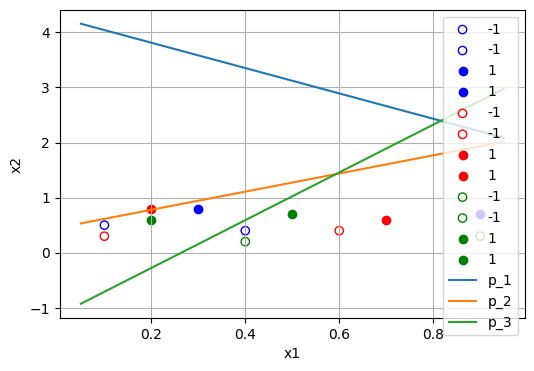

In [25]:
plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green']

for j in range(len_j):
    for l in range(4):
        if L[j][l, 2] == 1:
            plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
        else:
            plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

plt.plot(test_x, test_y_1, label="p_1")
plt.plot(test_x, test_y_2, label="p_2")
plt.plot(test_x, test_y_3, label="p_3")


plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

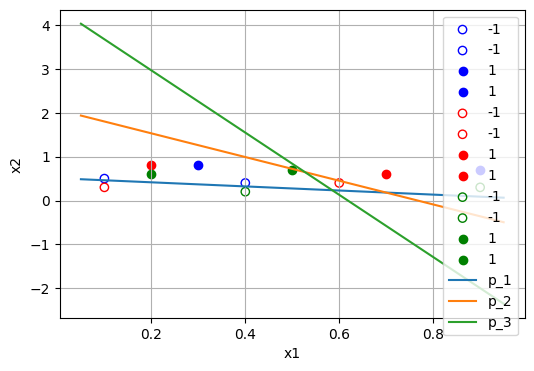

In [15]:
plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green']

for j in range(len_j):
    for l in range(4):
        if L[j][l, 2] == 1:
            plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
        else:
            plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

plt.plot(test_x, test_y_1, label="p_1")
plt.plot(test_x, test_y_2, label="p_2")
plt.plot(test_x, test_y_3, label="p_3")


plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()